<a href="https://colab.research.google.com/github/skojaku/cidre/blob/second-edit/examples/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this notebook

In this notebook, we apply CIDRE to a network with communities and demonstrate how to use CIDRE and visualize the detected groups.

## Preparation

### Install CIDRE package

First, we install `cidre` package with `pip`:

In [1]:
!pip install cidre

     |████████████████████████████████| 13.1 MB 85 kB/s 
     |████████████████████████████████| 28.5 MB 46 kB/s 
     |████████████████████████████████| 76 kB 3.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.



### Loading libraries

Next, we load some libraries

In [2]:
import sys
import numpy as np
from scipy import sparse
import pandas as pd
import cidre
import networkx as nx

# Example 1

We first present an example of a small artificial network, which can be loaded by

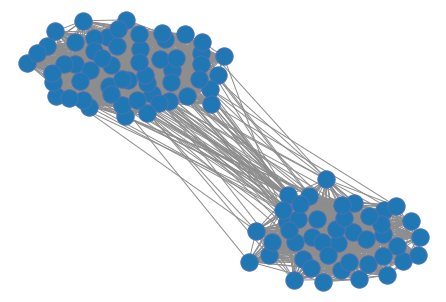

In [31]:
# Data path
edge_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/synthe/edge-table.csv"
node_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/synthe/node-table.csv"

# Load
node_table = pd.read_csv(node_file)
A, node_labels = cidre.utils.read_edge_list(edge_file)

# Visualization
nx.draw(nx.from_scipy_sparse_matrix(A), linewidths = 1, edge_color="#8d8d8d", edgecolors="b")

## About this network

We constructed this synthetic network by generating a network using a stochastic block model (SBM) composed of two blocks and then adding excessive citation edges among uniformly randomly selected pairs of nodes. Each block corresponds to a community, i.e., a group of nodes that are densely connected with each other within it but sparsely connected with those in the opposite group. Such communities overshadow anomalous groups in networks. 

## Community detection with graph-tool

Let's pretend that we do not know that the network is composed of two communities plus additional edges. To run CIDRE, we first need to find the communities. We use [graph-tool package](https://graph-tool.skewed.de/) to do this, which can be installed by 

```bash
conda install -c conda-forge graph-tool
```

or in `Colaboratory` platform:

In [4]:
%%capture
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib

Now, let's detect communities by fitting the degree-corrected stochastic block model (dcSBM) to the network and consider each detected block as a community.

In [5]:
import graph_tool.all as gt

def detect_community(A, K = None, **params):
    """Detect communities using the graph-tool package

    :param A: adjacency matrix
    :type A: scipy.csr_sparse_matrix
    :param K: Maximum number of communities. If K = None, the number of communities is automatically determined by graph-tool.
    :type K: int or None
    :param params: parameters passed to graph_tool.gt.minimize_blockmodel_dl
    """
    def to_graph_tool_format(adj, membership=None):
        g = gt.Graph(directed=True)
        r, c, v = sparse.find(adj)
        nedges = v.size
        edge_weights = g.new_edge_property("double")
        g.edge_properties["weight"] = edge_weights
        g.add_edge_list(
            np.hstack([np.transpose((r, c)), np.reshape(v, (nedges, 1))]),
            eprops=[edge_weights],
        )
        return g
    G = to_graph_tool_format(A)

    states = gt.minimize_blockmodel_dl(
        G,
        state_args=dict(eweight=G.ep.weight),
        multilevel_mcmc_args = {"B_max": A.shape[0] if K is None else K },
        **params
    )
    b = states.get_blocks()
    return np.unique(np.array(b.a), return_inverse = True)[1]

/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/draw/cairo_draw.py:32: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/usr/lib/python3/dist-packages/graph_tool/all.py:39: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo._cairo'
  warnings.warn(msg, RuntimeWarning)


In [6]:
group_membership = detect_community(A)

## Detecting anomalous groups in the network

Now, we feed the network and its community structure to CIDRE. To to this, we create a `cidre.Cidre` object and input `group_membership` along with some key parameters to `cidre.Cidre`.

In [7]:
alg = cidre.Cidre(group_membership = group_membership, alpha = 0.05, min_edge_weight = 1)

- `alpha` (default 0.01) is the statistical significance level.
- `min_edge_weight` is the threshold of the edge weight, i.e., the edges with weight less than this value will be removed.

Then, we input the network to `cidre.Cidre.detect`.

In [8]:
groups = alg.detect(A, threshold=0.15)

`groups` is a list of `Group` instances. A `Group` instance represents a group of nodes detected by CIDRE and contains information about the type of each member node (i.e., donor and recipient). We can get the donor nodes of a group, for example `groups[0]`, by

In [9]:
groups[0].donors

{56: 0.16535433070866143}

The keys and values of this dict object are the IDs of the nodes and their donor scores, respectively. The recipients and their recipient scores can be obtained by

In [10]:
groups[0].recipients

{63: 0.1694915254237288, 99: 0.15714285714285714}

## Visualization

`cidre` package provides an API to visualize small groups. To use this API, we first need to import some additional libraries.

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

Then, plot the group by

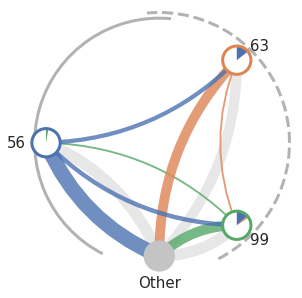

In [12]:
# The following three lines are purely for visual enhancement, i.e., changing the saturation of the colors and font size.
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

# Set the figure size
width, height = 5,5
fig, ax = plt.subplots(figsize=(width, height))

# Plot a citation group
cidre.DrawGroup().draw(groups[0], ax = ax)


# Example 2

Let's apply CIDRE to a much larger empirical citation network, i.e., the citation network of journals in 2013.

In [13]:
# Data path
edge_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/edge-table-2013.csv"
node_file = "https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/community-label.csv"

# Load
node_table = pd.read_csv(node_file)
A, node_labels = cidre.utils.read_edge_list(edge_file)

## About this network

This network is a citation network of journals in 2013 constructed from Microsoft Academic Graph.
Each edge is weighted by the number of citations made to the papers in the prior two years.
The following are basic statistics of this network.

In [14]:
print("Number of nodes: %d" % A.shape[0])
print("Number of edges: %d" % A.sum())
print("Average degree: %.2f" % (A.sum()/A.shape[0]))
print("Max in-degree: %d" % np.max(A.sum(axis = 0)))
print("Max out-degree: %d" % np.max(A.sum(axis = 1)))
print("Maximum edge weight: %d" % A.max())
print("Minimum edge weight: %d" % np.min(A.data))

Number of nodes: 31385
Number of edges: 8038733
Average degree: 256.13
Max in-degree: 143633
Max out-degree: 228866
Maximum edge weight: 19792
Minimum edge weight: 1


## Communities

[In our paper](https://www.nature.com/articles/s41598-021-93572-3), we identified the communities of journals using [graph-tool](https://graph-tool.skewed.de/). `node_table` contains the community membership of each journal, from which we prepare `group_membership` array as follows.

In [15]:
# Get the group membership
node2com = dict(zip(node_table["journal_id"], node_table["community_id"]))
group_membership = [node2com[node_labels[i]] for i in range(A.shape[0])]

## Detecting anomalous groups in the network

As is demonstrated in the first example, we detect the anomalous groups in the network by

In [16]:
alg = cidre.Cidre(group_membership = group_membership, alpha = 0.01, min_edge_weight = 10)
groups = alg.detect(A, threshold=0.15)

In [17]:
print("The number of journals in the largest group: %d" % np.max([group.size() for group in groups]))
print("Number of groups detected: %d" % len(groups))

The number of journals in the largest group: 16
Number of groups detected: 129


[In our paper](https://www.nature.com/articles/s41598-021-93572-3), we omitted the groups that have within-group citations less than 50 because we expect that anomalous citation groups contain sufficiently many within-group citations, i.e., 

In [18]:
groups = [group for group in groups if group.get_num_edges()>=50]

where `group.get.num_edges()` gives the sum of the weights of the non-self-loop edges within the group.

## Visualization

Let us visualize the groups detected by CIDRE. For expository purposes, we sample three groups to visualize uniformly at random.

In [26]:
groups_sampled = [groups[i] for i in np.random.choice(len(groups), 3, replace = False)]

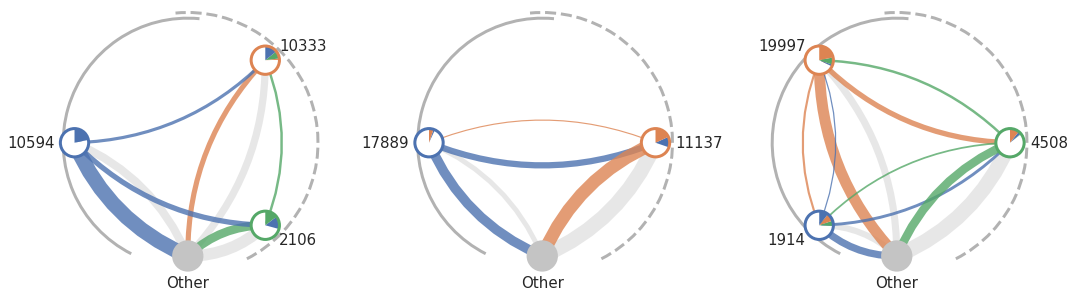

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(6 * 3, 5))

for i in range(3):
    cidre.DrawGroup().draw(groups_sampled[i], ax = axes.flat[i])

The numbers beside the nodes are the IDs of the journals in the network. To show the journals' names, we do the following. 


First, we load node lables and make a dictionary that maps the ID of each node to the label:

In [28]:
df = pd.read_csv("https://raw.githubusercontent.com/skojaku/cidre/main/data/journal-citation/journal_names.csv")
journalid2label = dict(zip(df.journal_id.values, df.name.values)) # Dictionary from MAG journal ID to the journal name

id2label = {k:journalid2label[v] for k, v in node_labels.items()} # This is a dictionary from ID to label, i.e., {ID:journal_name}

Then, give `id2label` to `cidre.DrawGroup.draw`, i.e.,  

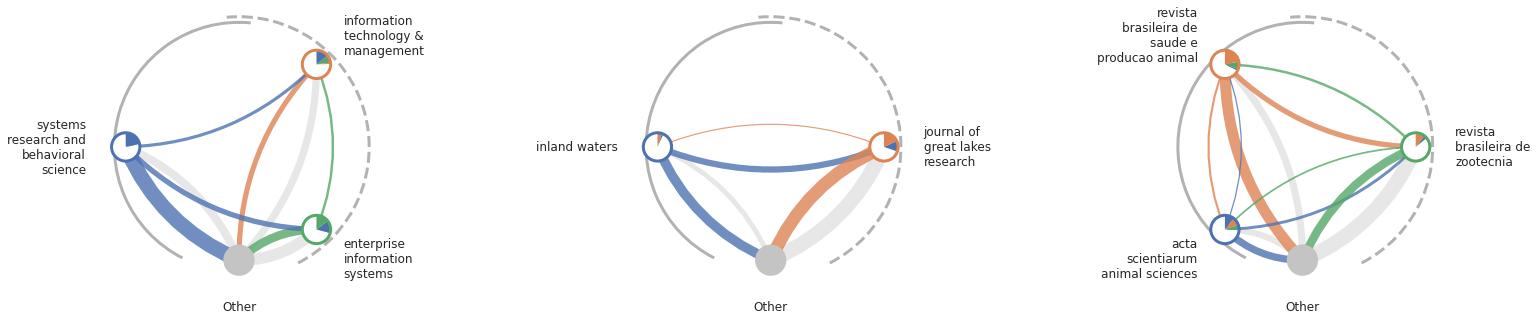

In [29]:
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, axes = plt.subplots(ncols = 3, figsize=(9 * 3, 5))

for i in range(3):
    plotter = cidre.DrawGroup()
    plotter.font_size = 12 # Font size
    plotter.label_node_margin = 0.7 # Margin between labels and node
    plotter.draw(groups_sampled[i], node_labels = id2label, ax = axes.flat[i])